# **NYC Restaurant Inspections Processing**

Joe Lardie

September 2023

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder

#Scipy
from scipy import stats
from scipy.stats import norm

#Sklearn Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, set_config
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
set_config(display = 'diagram')

In [2]:
#Derek You need this one
#pip install nltk

In [3]:
#nltk.download('stopwords')

# **Data Dictionary**
**DBA**	This field represents the name (doing business as) of the entity (restaurant); Public business name, may change at discretion of restaurant owner

**BORO**	Borough in which the entity (restaurant) is located.;• 1 = MANHATTAN • 2 = BRONX • 3 = BROOKLYN • 4 = QUEENS • 5 = STATEN ISLAND • Missing; NOTE: There may be discrepancies between zip code and listed boro due to differences in an establishment's mailing address and physical location

**BUILDING**  Building number for establishment (restaurant) location

**STREET**	Street name for establishment (restaurant) location

**ZIPCODE**	Zip code of establishment (restaurant) location

**PHONE**	Phone Number; Phone number provided by restaurant owner/manager

**CUISINE DESCRIPTION**	This field describes the entity (restaurant) cuisine. ; Optional field provided by provided by restaurant owner/manager

**INSPECTION DATE**	This field represents the date of inspection; NOTE: Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection

**ACTION**	This field represents the actions that is associated with each restaurant inspection. ; • Violations were cited in the following area(s). • No violations were recorded at the time of this inspection. • Establishment re-opened by DOHMH • Establishment re-closed by DOHMH • Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed. • "Missing" = not yet inspected;

**VIOLATION CODE**	Violation code associated with an establishment (restaurant) inspection

**VIOLATION DESCRIPTION**Violation description associated with an establishment (restaurant) inspection

**CRITICAL FLAG**	Indicator of critical violation; "• Critical • Not Critical • Not Applicable"; Critical violations are those most likely to contribute to food-borne illness

**SCORE**Total score for a particular inspection; Scores are updated based on adjudication results

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

**GRADE DATE**	The date when the current grade was issued to the entity (restaurant)

**RECORD DATE**	The date when the extract was run to produce this data set

**INSPECTION TYPE** A combination of the inspection program and the type of inspection performed; See Data Dictionary for full list of expected values


## **Important Context**

RECORD DATE = (date of the data pull).

Restaurants that received no violations are represented by a single row and coded as having no violations using the ACTION field.

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.

Establishments are uniquely identified by their CAMIS (record ID) number.

# **Import Data**

In [4]:
# Loading NYC Restaraunt Data
rdf = pd.read_csv('rdf')

In [5]:
# Glance of inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204870 entries, 0 to 204869
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  204870 non-null  int64  
 1   DBA                    204384 non-null  object 
 2   BORO                   204870 non-null  object 
 3   BUILDING               204574 non-null  object 
 4   STREET                 204866 non-null  object 
 5   ZIPCODE                202148 non-null  float64
 6   CUISINE DESCRIPTION    202618 non-null  object 
 7   INSPECTION DATE        204870 non-null  object 
 8   ACTION                 202618 non-null  object 
 9   VIOLATION CODE         201486 non-null  object 
 10  VIOLATION DESCRIPTION  201486 non-null  object 
 11  CRITICAL FLAG          204870 non-null  object 
 12  SCORE                  195426 non-null  float64
 13  GRADE                  101512 non-null  object 
 14  GRADE DATE             91760 non-nul

# **Data Cleaning**

In [6]:
# checking missing data in data 
total = rdf.isnull().sum().sort_values(ascending = False)
percent = (rdf.isnull().sum()/rdf.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
GRADE DATE,113110,55.210621
GRADE,103358,50.450530
SCORE,9444,4.609753
VIOLATION CODE,3384,1.651779
VIOLATION DESCRIPTION,3384,1.651779
Council District,3250,1.586372
ZIPCODE,2722,1.328647
CUISINE DESCRIPTION,2252,1.099234
ACTION,2252,1.099234
INSPECTION TYPE,2252,1.099234


Grade, Score, and Grade date - missing a lot of data due to some places not yet receiving an inspection
DBA needs to reference CAMIS to ensure the situation surrounding the repeated rows
Inspection Type may be related to places not yet received an inspection


In [7]:
rdf['SCORE'].describe()

count    195426.000000
mean         22.557167
std          17.409817
min           0.000000
25%          11.000000
50%          18.000000
75%          30.000000
max         168.000000
Name: SCORE, dtype: float64

In [36]:
rdf['DBA'].value_counts()

DUNKIN                        2540
SUBWAY                        1500
STARBUCKS                     1124
MCDONALD'S                    1018
KENNEDY FRIED CHICKEN          690
                              ... 
KORE COFFEE                      1
FLEUR CAFE                       1
INTERNET AND COFFEE              1
HABIBI  BAR AND RESTAURANT       1
DEAR IRVING                      1
Name: DBA, Length: 21920, dtype: int64

This should mean that there are 21,920 different restaurants

In [35]:
rdf['CAMIS'].value_counts()

40398688    65
50045647    56
40365904    52
41406895    50
50111296    49
            ..
50045065     1
50076912     1
50044782     1
50045110     1
50009923     1
Name: CAMIS, Length: 27960, dtype: int64

This should mean that there are 27960 total different restaurants inspected

In [8]:
rdf['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                          112968
Cycle Inspection / Re-inspection                                36009
Pre-permit (Operational) / Initial Inspection                   30055
Pre-permit (Operational) / Re-inspection                         8906
Administrative Miscellaneous / Initial Inspection                4728
Pre-permit (Non-operational) / Initial Inspection                2437
Pre-permit (Operational) / Compliance Inspection                 1486
Cycle Inspection / Reopening Inspection                          1414
Administrative Miscellaneous / Re-inspection                      925
Pre-permit (Operational) / Reopening Inspection                   697
Cycle Inspection / Compliance Inspection                          681
Smoke-Free Air Act / Initial Inspection                           545
Trans Fat / Initial Inspection                                    378
Inter-Agency Task Force / Initial Inspection                      342
Calorie Posting / In

In [9]:
# Looking at different Restaurant Types, Potential to filter out specific types for geospacial analysis
all_unique_values = rdf['CUISINE DESCRIPTION'].unique()
print(all_unique_values)

[nan 'American' 'Other' 'Chinese' 'Salads' 'Caribbean' 'Frozen Desserts'
 'Korean' 'Latin American' 'Spanish' 'Italian' 'French' 'Indonesian'
 'Japanese' 'German' 'Filipino' 'Vegetarian' 'Pizza' 'Continental' 'Thai'
 'Sandwiches' 'African' 'Indian' 'Mexican' 'Vegan' 'Coffee/Tea'
 'Steakhouse' 'Hotdogs' 'Turkish' 'Peruvian' 'Australian' 'Creole' 'Greek'
 'Sandwiches/Salads/Mixed Buffet' 'Southeast Asian' 'Middle Eastern'
 'Hawaiian' 'Asian/Asian Fusion' 'Donuts' 'Jewish/Kosher' 'Chicken'
 'Juice, Smoothies, Fruit Salads' 'Bakery Products/Desserts' 'Seafood'
 'New American' 'Hamburgers' 'Pancakes/Waffles' 'Pakistani'
 'Mediterranean' 'Bagels/Pretzels' 'Tex-Mex' 'Chilean' 'Egyptian' 'Irish'
 'Bangladeshi' 'Basque' 'Barbecue' 'Lebanese' 'Bottled Beverages'
 'Eastern European' 'Nuts/Confectionary' 'Not Listed/Not Applicable'
 'Soul Food' 'Soups/Salads/Sandwiches' 'English' 'Chinese/Japanese'
 'Iranian' 'Fusion' 'Russian' 'Polish' 'Brazilian' 'Tapas' 'Afghan'
 'Ethiopian' 'Cajun' 'Fruits/Veg

## **Grade Date by Year**

In [10]:
# Convert the 'GRADE DATE' column to datetime type
rdf['GRADE DATE'] = pd.to_datetime(rdf['GRADE DATE'])

# Filter rows for the year 2016
desired_year = 2023
filtered_df = rdf[rdf['GRADE DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df)

           CAMIS                          DBA       BORO BUILDING  \
38      50118139              LUCKY CAFETERIA     Queens     3626   
48      50033660               RUSTY'S FLAVOR  Manhattan     2261   
51      50070203                  FIVE SENSES  Manhattan        9   
70      50045071                   PRESS ROOM  Manhattan        4   
78      50106148                     QUATORZE  Manhattan     1578   
...          ...                          ...        ...      ...   
204837  50066221               LIBERTY BISTRO  Manhattan      225   
204840  50129422                SPRING GARDEN   Brooklyn     4710   
204847  41630104     LUCKY CHINESE RESTAURANT     Queens     5008   
204848  50066692  MAY WAH PORK CHOP FAST FOOD  Manhattan      190   
204866  50116198            GELATERIA GENTILE  Manhattan       75   

                                  STREET  ZIPCODE CUISINE DESCRIPTION  \
38                              UNION ST  11354.0             Chinese   
48      ADAM CLAYTON POWE

2016 = 293

2017 = 934

2018 = 1358

2019 = 6832

2020 = 5339

2021 = 7878

2022 = 38820

2023 = 30296

## **Inspection Date by Year**

2016 = 483

2017 = 1578

2018 = 2340

2019 = 13033

2020 = 10562

2021 = 20800

2022 = 88263

2023 = 65539

In [11]:
# Convert the 'GRADE DATE' column to datetime type
rdf['INSPECTION DATE'] = pd.to_datetime(rdf['INSPECTION DATE'])

# Filter rows for the year 2016
desired_year = 2023
filtered_df = rdf[rdf['INSPECTION DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df)

           CAMIS                          DBA       BORO BUILDING  \
38      50118139              LUCKY CAFETERIA     Queens     3626   
48      50033660               RUSTY'S FLAVOR  Manhattan     2261   
51      50070203                  FIVE SENSES  Manhattan        9   
52      50091763                   SWEETGREEN  Manhattan      125   
68      50090686               LA GATA GOLOSA     Queens     3018   
...          ...                          ...        ...      ...   
204847  41630104     LUCKY CHINESE RESTAURANT     Queens     5008   
204848  50066692  MAY WAH PORK CHOP FAST FOOD  Manhattan      190   
204856  50109069        NATIONAL BURGER HOUSE      Bronx      470   
204866  50116198            GELATERIA GENTILE  Manhattan       75   
204868  50113275        CHORUS KARAOKE LOUNGE  Manhattan       25   

                                  STREET  ZIPCODE CUISINE DESCRIPTION  \
38                              UNION ST  11354.0             Chinese   
48      ADAM CLAYTON POWE

# **Visualizations**

# **Scores**

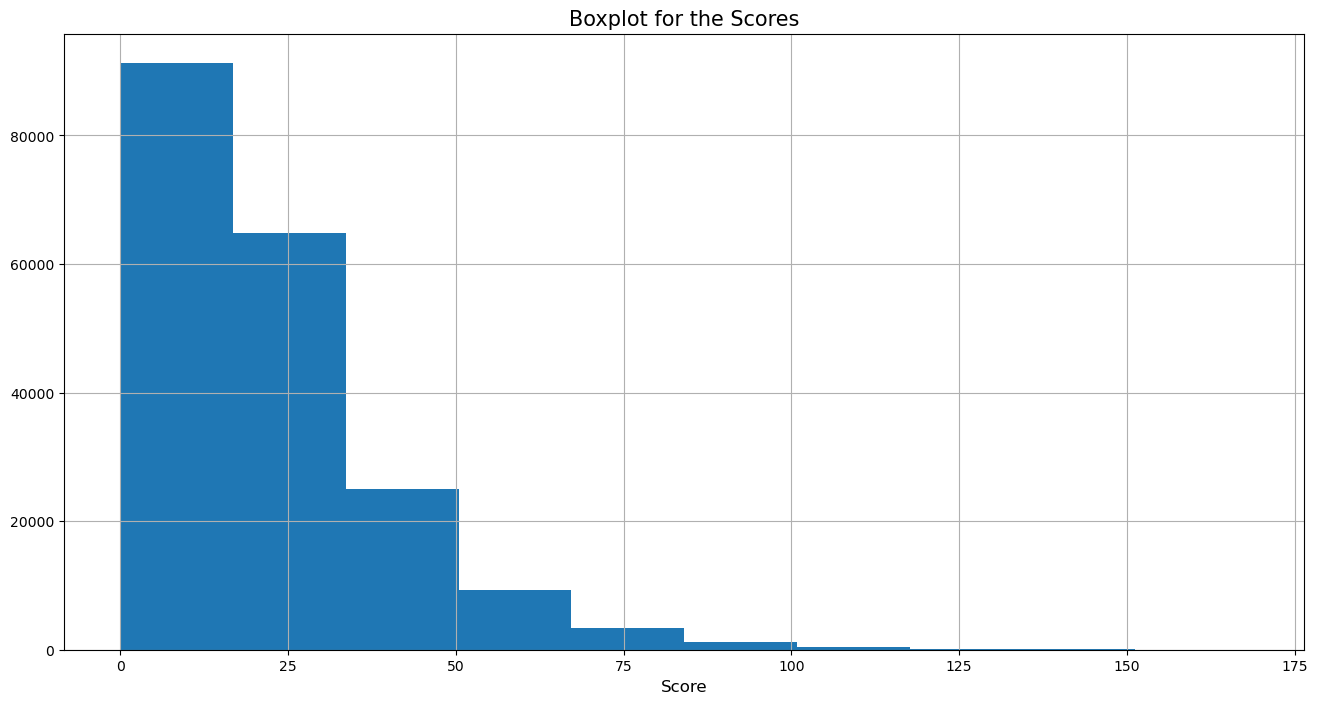

In [12]:
# Plot a histogram
rdf.SCORE.hist(figsize=(16,8))
plt.title("Boxplot for the Scores", fontsize=15)
plt.xlabel('Score', fontsize = 12);

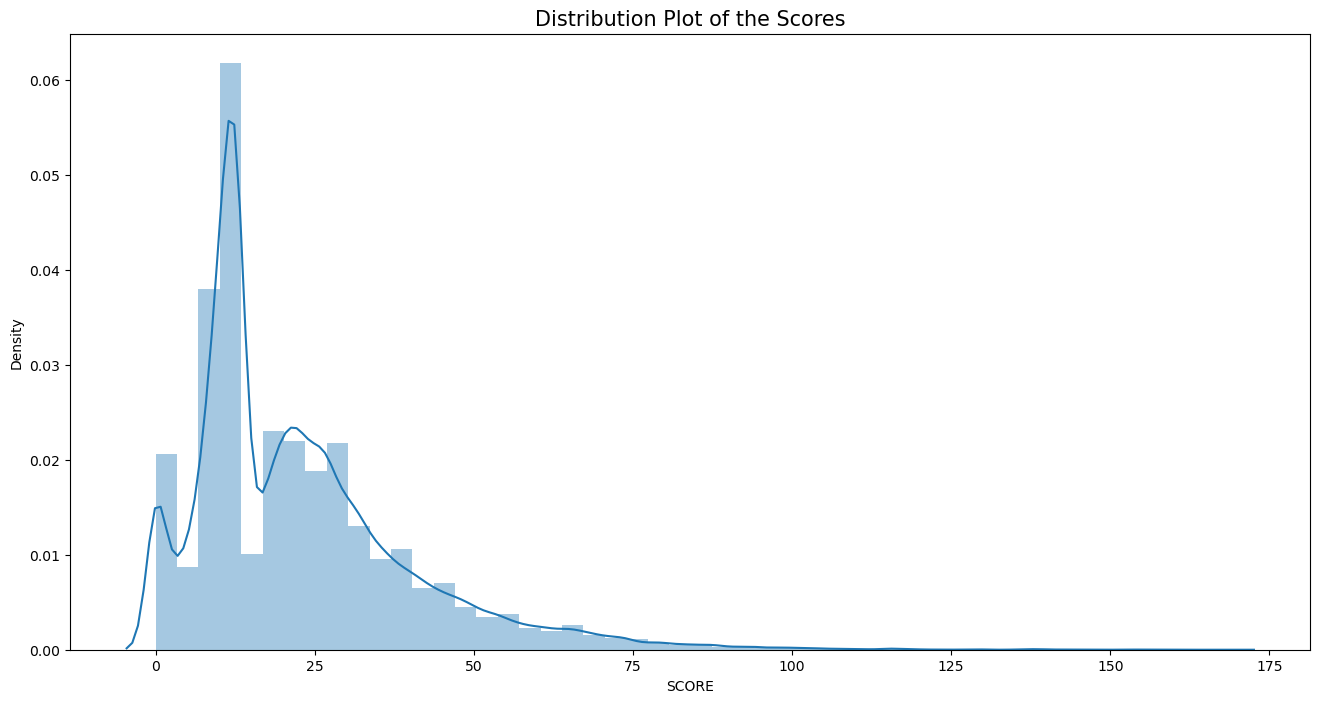

In [13]:
# Have a look at a distribution plot of the Score
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
sns.distplot(rdf.SCORE.dropna())
plt.title("Distribution Plot of the Scores", fontsize=15);

## **NYC Boros**

# **Important Context:**

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

In [14]:
# Filter rows where 'BORO' is 0
f_df = rdf[rdf['BORO'] == '0']

# Display the filtered DataFrame
print(f_df)

           CAMIS                         DBA BORO BUILDING           STREET  \
36      50141174              CHOMPS ELYSEES    0      NaN              NaN   
61      50140778                         NaN    0      NaN              NaN   
179     50115885             PIZZA HUT 38746    0      760       FULTON AVE   
305     50139597                         NaN    0      NaN              NaN   
324     50141088                         NaN    0       23    PARK HILL AVE   
505     50123437                         NaN    0      274     ATLANTIC AVE   
645     50140411  TAIM MEDITERRANEAN KITCHEN    0     1006   BROADHOLLOW RD   
693     50140500  TAIM MEDITERRANEAN KITCHEN    0      397  S OYSTER BAY RD   
1704    50127295                         NaN    0      247   HEMPSTEAD TPKE   
20154   50126672                         NaN    0        2   SHADY BROOK LN   
128983  50128762                         NaN    0       33         NORTH DR   
147693  50139890                         NaN    0   

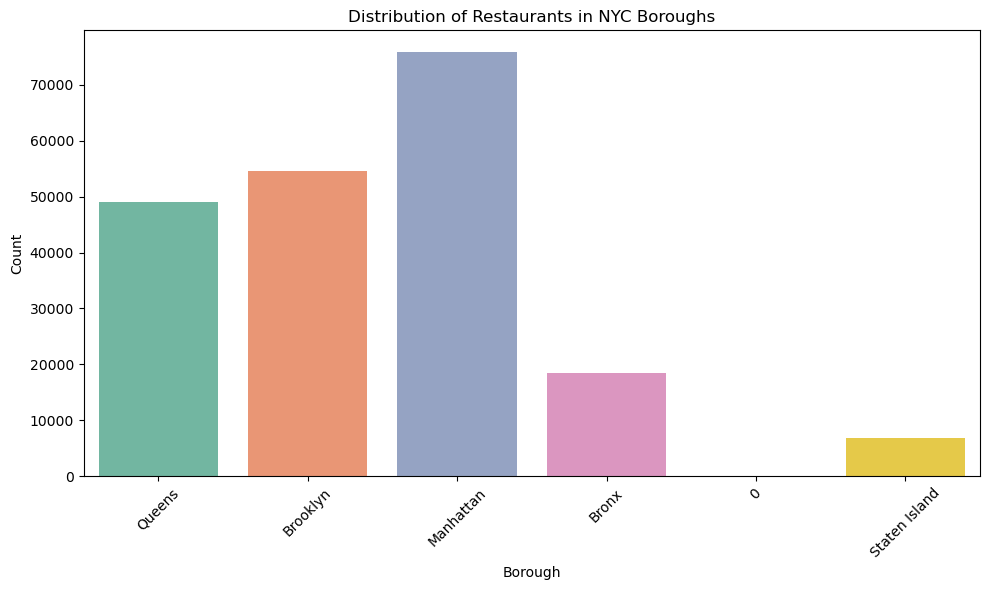

In [15]:
# Visualizing Distribution of Restaurants in NYC Boroughs
plt.figure(figsize=(10, 6))
sns.countplot(data=rdf, x='BORO', palette='Set2') 
plt.title('Distribution of Restaurants in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

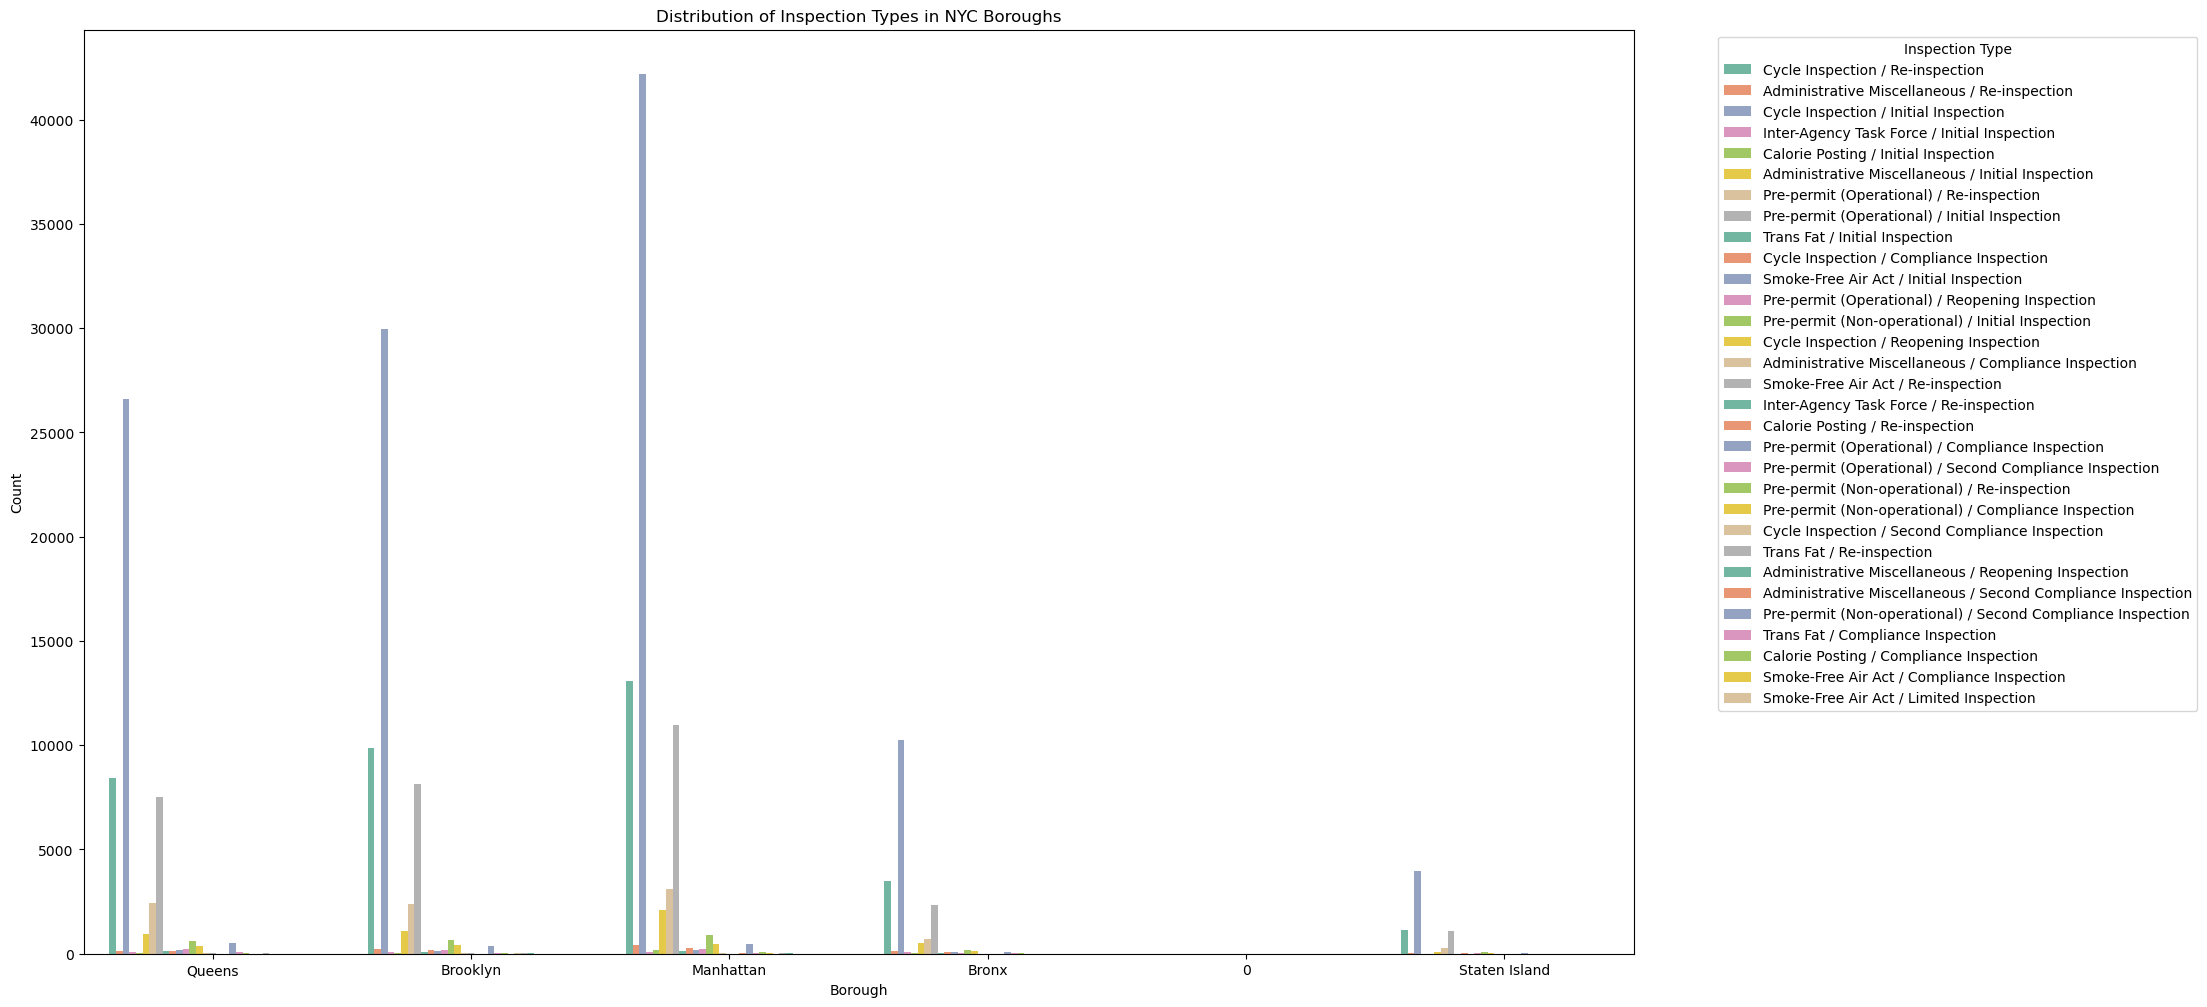

In [16]:
# Create a stacked bar chart using Seaborn
plt.figure(figsize=(20,12))
sns.countplot(x='BORO', hue='INSPECTION TYPE', data=rdf, palette='Set2')
plt.title('Distribution of Inspection Types in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')

# Show the plot
plt.legend(title='Inspection Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

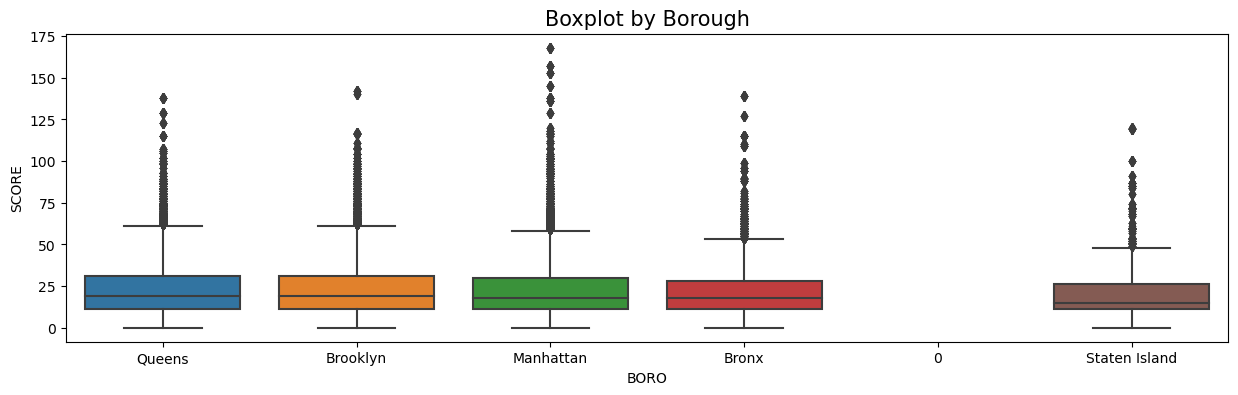

In [17]:
# Create a boxplot using Seaborn
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='BORO', y='SCORE', data=rdf)
plt.title('Boxplot by Borough', fontsize=15)

# Show the plot
plt.show()

In [18]:
# Contingency table for Grade and Borough
boro_grade = pd.crosstab(rdf.GRADE, rdf.BORO, margins = True)
boro_grade

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island,All
GRADE,,,,,,
A,6070,18249,26772,16501,2865,70457
B,1094,2901,3675,2697,372,10739
C,550,1654,2223,1655,116,6198
N,847,2285,3806,2484,341,9763
P,52,174,207,129,10,572
Z,408,860,1259,1124,132,3783
All,9021,26123,37942,24590,3836,101512


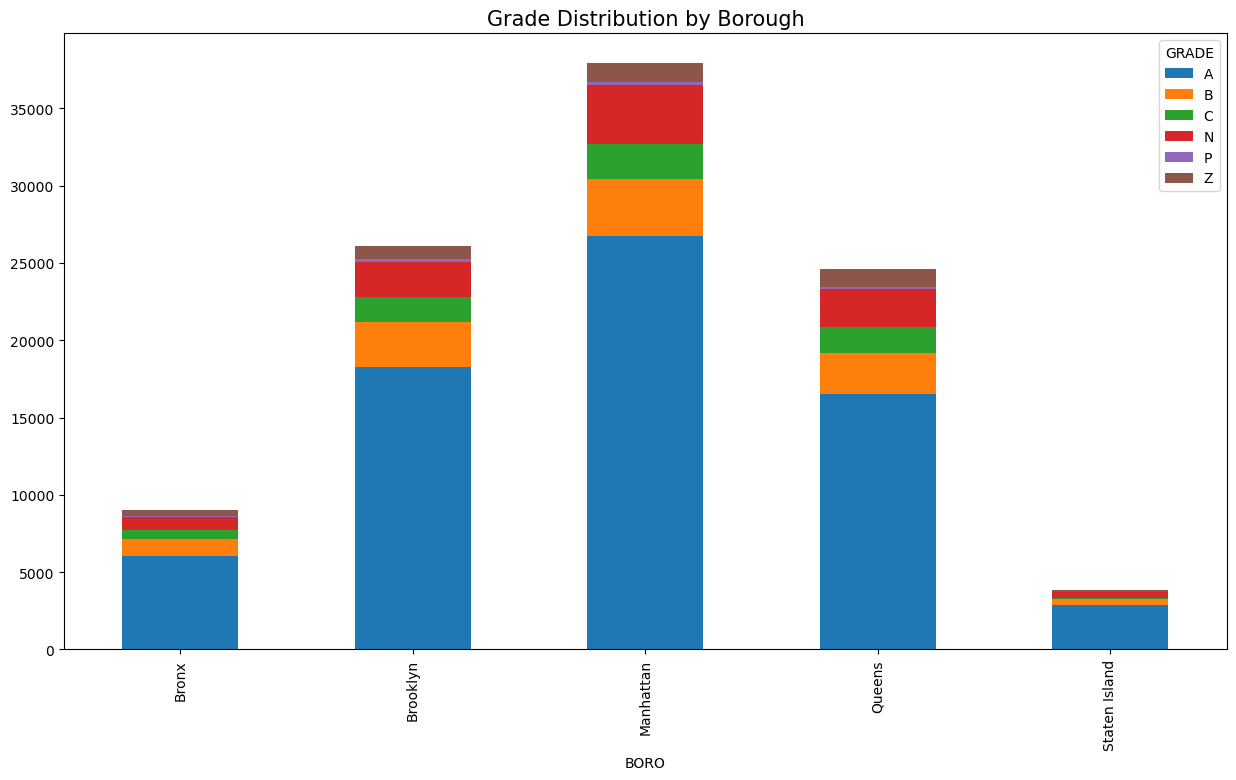

In [19]:
# Plot of grade by borough
pd.crosstab(rdf.BORO, rdf.GRADE).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Grade Distribution by Borough', fontsize = 15);

In [20]:
# Test if the grades are independent of the borough
boro_grade.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND" ,"All"]

boro_grade.index = ["A","B","C","Not Yet Graded","P", "Z", "All"]

observed = boro_grade.iloc[0:6,0:5]   # Get table without totals for later use

expected =  np.outer(boro_grade["All"][0:6],
                     boro_grade.loc["All"][0:5]) / 1000

expected = pd.DataFrame(expected)

expected.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND"]
expected.index = ["A","B","C","Not Yet Graded","P", "Z"]

chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print("Chi Squared Stat")
print(chi_squared_stat)

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 20)   # (5-1) * (6-1)

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=20)
print("P value")
print(p_value)

stats.chi2_contingency(observed= observed)

Chi Squared Stat
10102665.424636917
Critical value
31.410432844230918
P value
0.0


(333.02401467210865,
 1.3866838712669045e-58,
 20,
 array([[6.26125578e+03, 1.81313363e+04, 2.63346156e+04, 1.70673184e+04,
         2.66247391e+03],
        [9.54335635e+02, 2.76356388e+03, 4.01390119e+03, 2.60138713e+03,
         4.05812160e+02],
        [5.50793581e+02, 1.59498733e+03, 2.31661790e+03, 1.50138723e+03,
         2.34213965e+02],
        [8.67602086e+02, 2.51240099e+03, 3.64910302e+03, 2.36496345e+03,
         3.68930452e+02],
        [5.08315470e+01, 1.47197927e+02, 2.13795650e+02, 1.38559776e+02,
         2.16150997e+01],
        [3.36181368e+02, 9.73513565e+02, 1.41396668e+03, 9.16383974e+02,
         1.42954409e+02]]))

## **Distribution of Grades**

Text(0.5, 1.0, 'Boxplot by Grade')

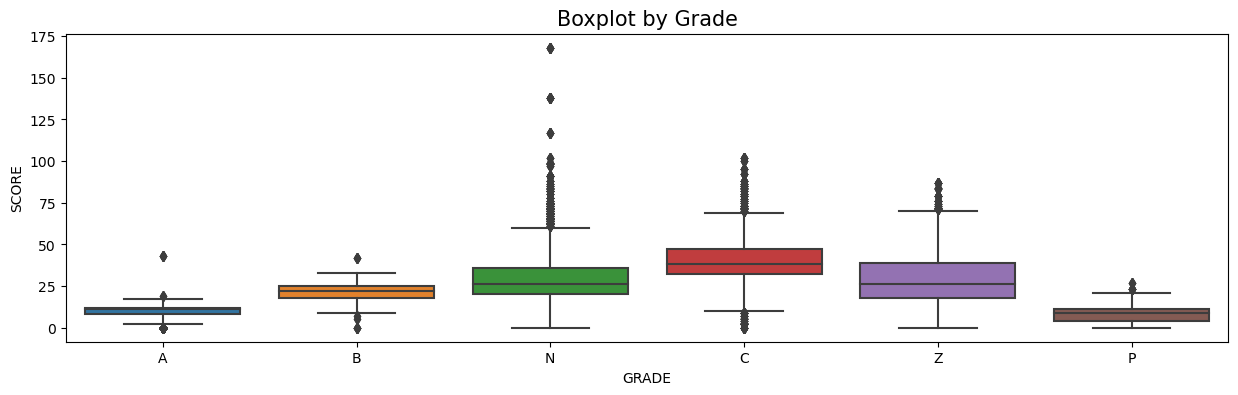

In [21]:
# Lets look at scores by grades with a Boxplot
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='GRADE', y='SCORE', data=rdf)
plt.title('Boxplot by Grade', fontsize = 15)

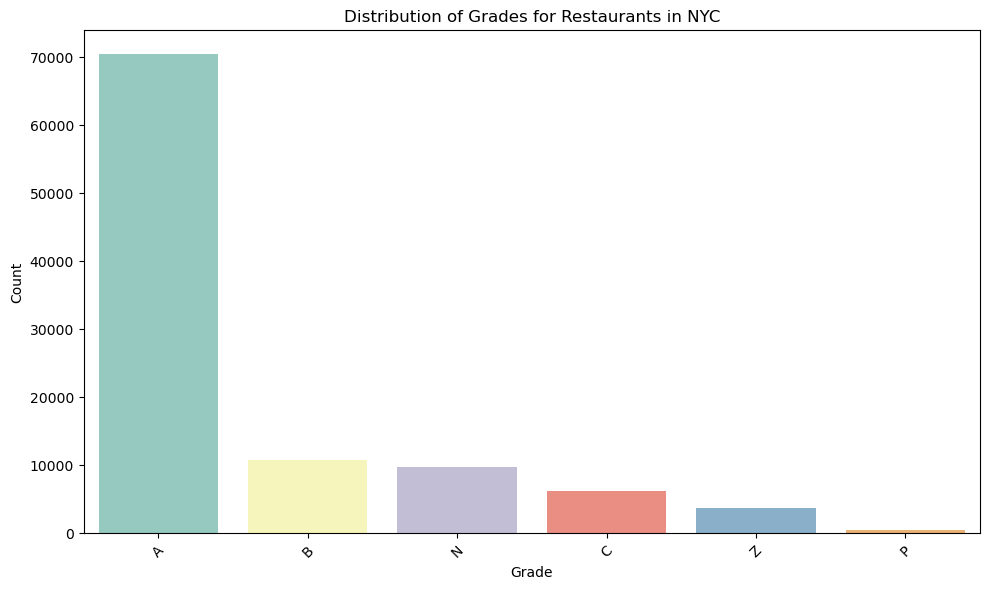

In [22]:
# Visualizing Distribution of Grades for Restaurants in NYC
plt.figure(figsize=(10, 6))
sns.countplot(data=rdf, x='GRADE', palette='Set3')  
plt.title('Distribution of Grades for Restaurants in NYC')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

## **Distribution of Cuisine Types**

In [23]:
# Filteriung out the irrelevant Cuisine Types for Visalization
min_cuisine_count = 1000
cuisine_counts = rdf['CUISINE DESCRIPTION'].value_counts()
filtered_cuisines = cuisine_counts[cuisine_counts >= min_cuisine_count].index
fdf = rdf[rdf['CUISINE DESCRIPTION'].isin(filtered_cuisines)]

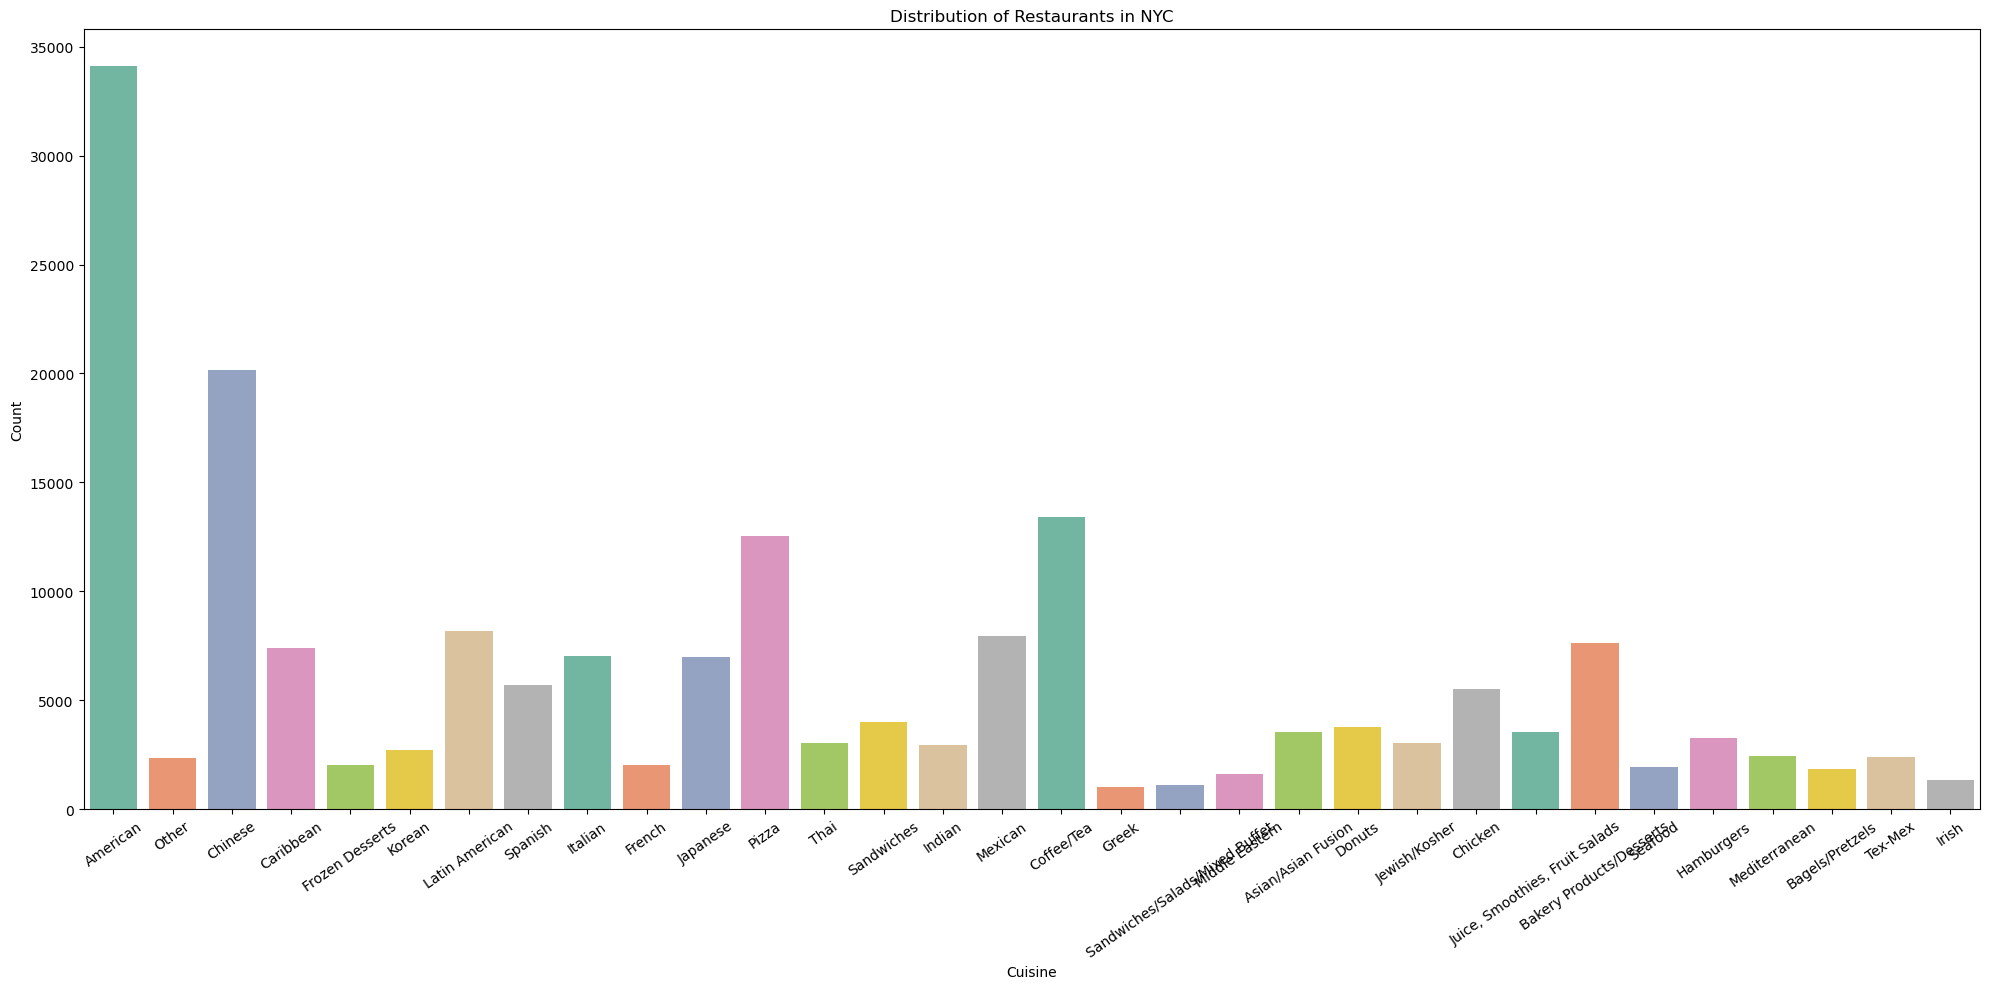

In [24]:
# Visualization of most popular cuisines
plt.figure(figsize=(20,10))
sns.countplot(data=fdf, x='CUISINE DESCRIPTION', palette='Set2') 
plt.title('Distribution of Restaurants in NYC')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=35) 

plt.tight_layout()
plt.show()

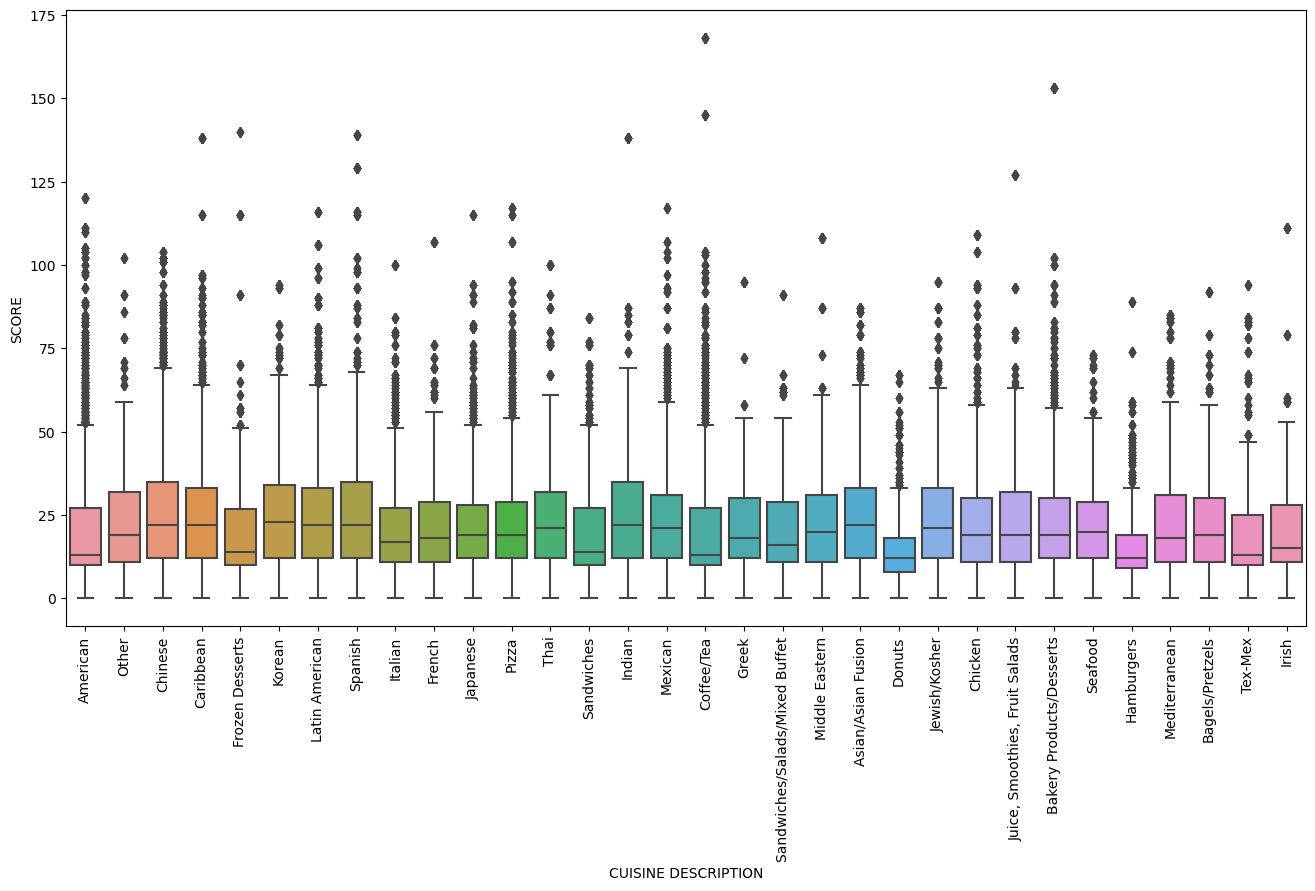

In [25]:
# Let us look at the scores by cuisine
score_cuisine = pd.concat([fdf['CUISINE DESCRIPTION'], fdf['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CUISINE DESCRIPTION', y="SCORE", data = fdf)
plt.xticks(rotation=90);

# **Action Analysis**

In [26]:
rdf.ACTION.value_counts()

Violations were cited in the following area(s).                                                                                       191900
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.      7728
Establishment re-opened by DOHMH.                                                                                                       1850
No violations were recorded at the time of this inspection.                                                                             1136
Establishment re-closed by DOHMH.                                                                                                          4
Name: ACTION, dtype: int64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Violations were cited in the following area(s).'),
  Text(1, 0, 'No violations were recorded at the time of this inspection.'),
  Text(2, 0, 'Establishment re-opened by DOHMH.'),
  Text(3, 0, 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'),
  Text(4, 0, 'Establishment re-closed by DOHMH.')])

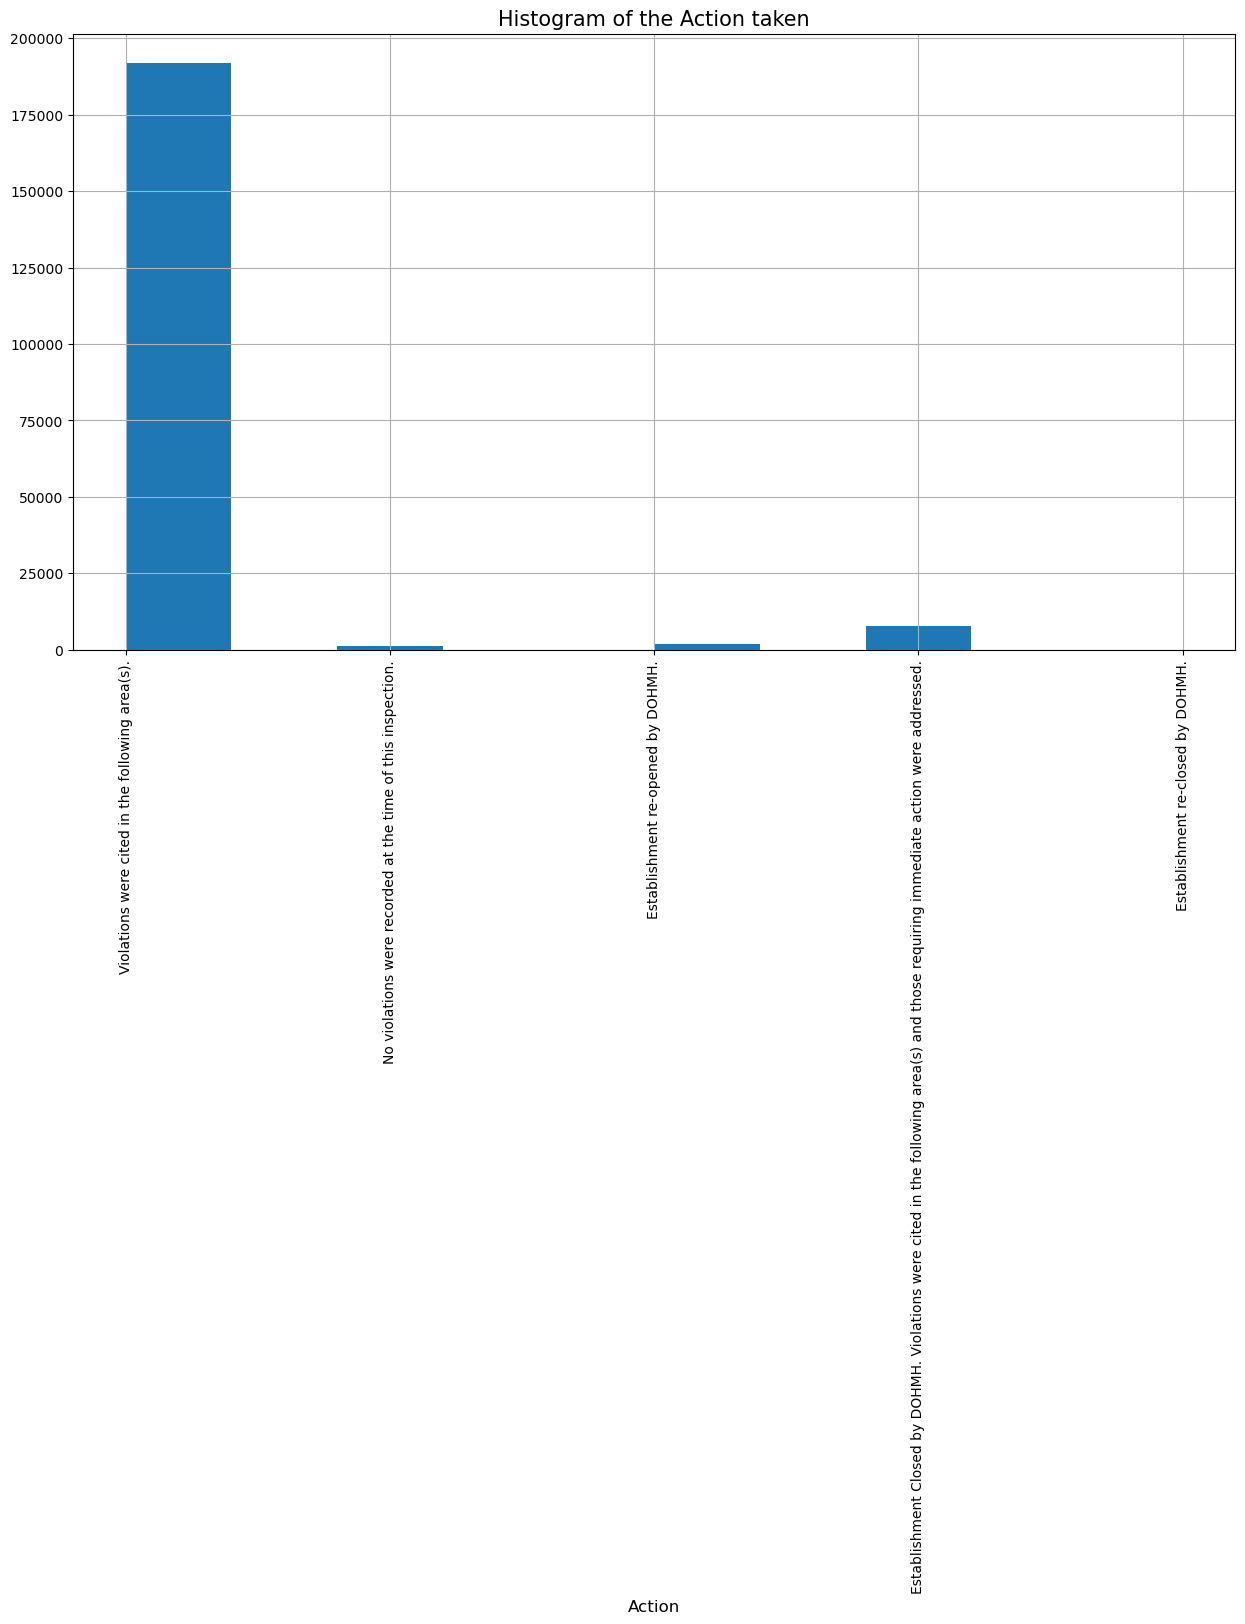

In [27]:
# Histogram of the Action taken
rdf.ACTION.hist(figsize = (15,8))
plt.title('Histogram of the Action taken', fontsize = 15)
plt.xlabel('Action', fontsize = 12)
plt.xticks(rotation=90)

In [28]:
rdf['CRITICAL FLAG'].value_counts()

Critical          111798
Not Critical       88432
Not Applicable      4640
Name: CRITICAL FLAG, dtype: int64

Text(0.5, 0, 'Flag')

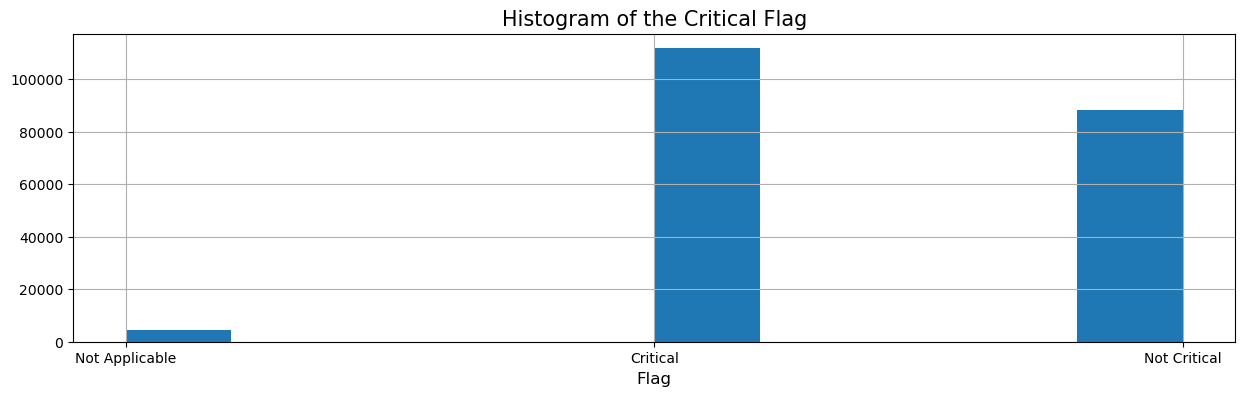

In [29]:
# Graphical representation of the critical flag
rdf['CRITICAL FLAG'].hist(figsize=(15,4))
plt.title('Histogram of the Critical Flag', fontsize = 15)
plt.xlabel('Flag', fontsize = 12)

Text(0.5, 1.0, 'Critical Flag by Borough')

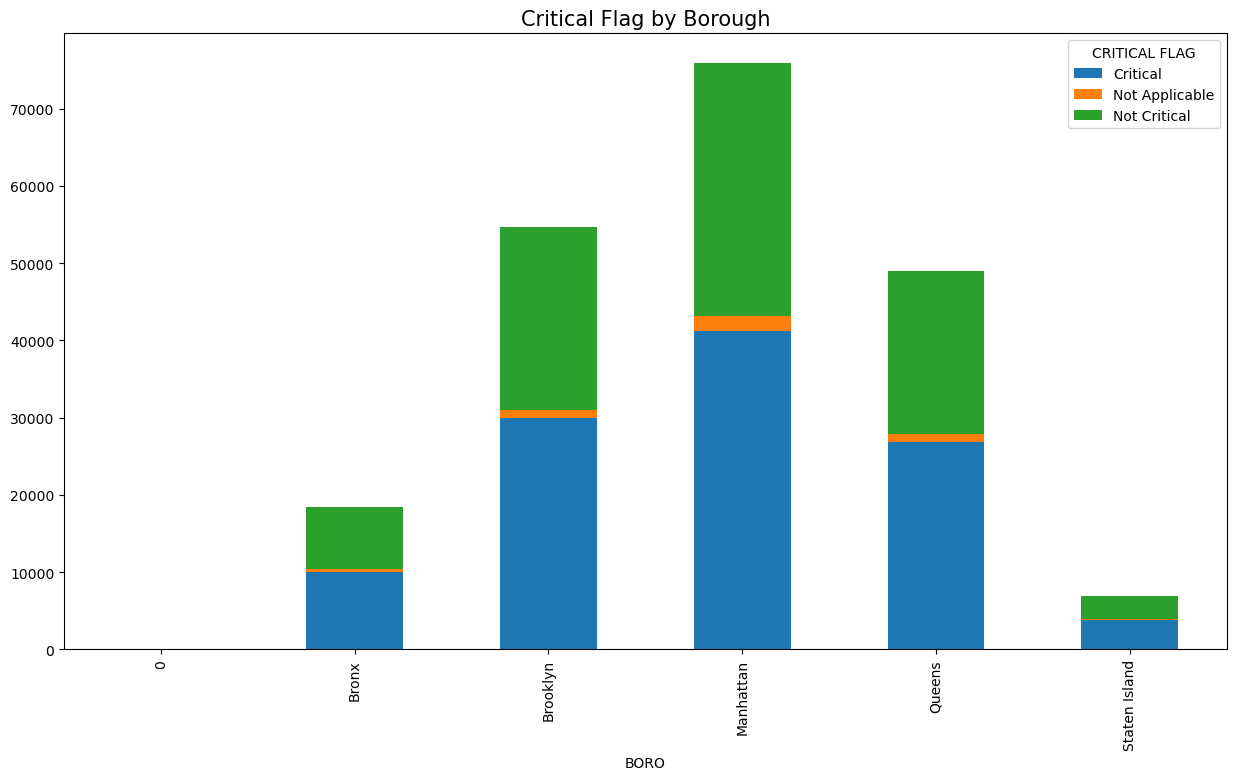

In [30]:
# Critical Flag by Borough
pd.crosstab(rdf.BORO, rdf['CRITICAL FLAG']).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Critical Flag by Borough', fontsize = 15)

Text(0.5, 1.0, 'Critical Flag by Cuisine')

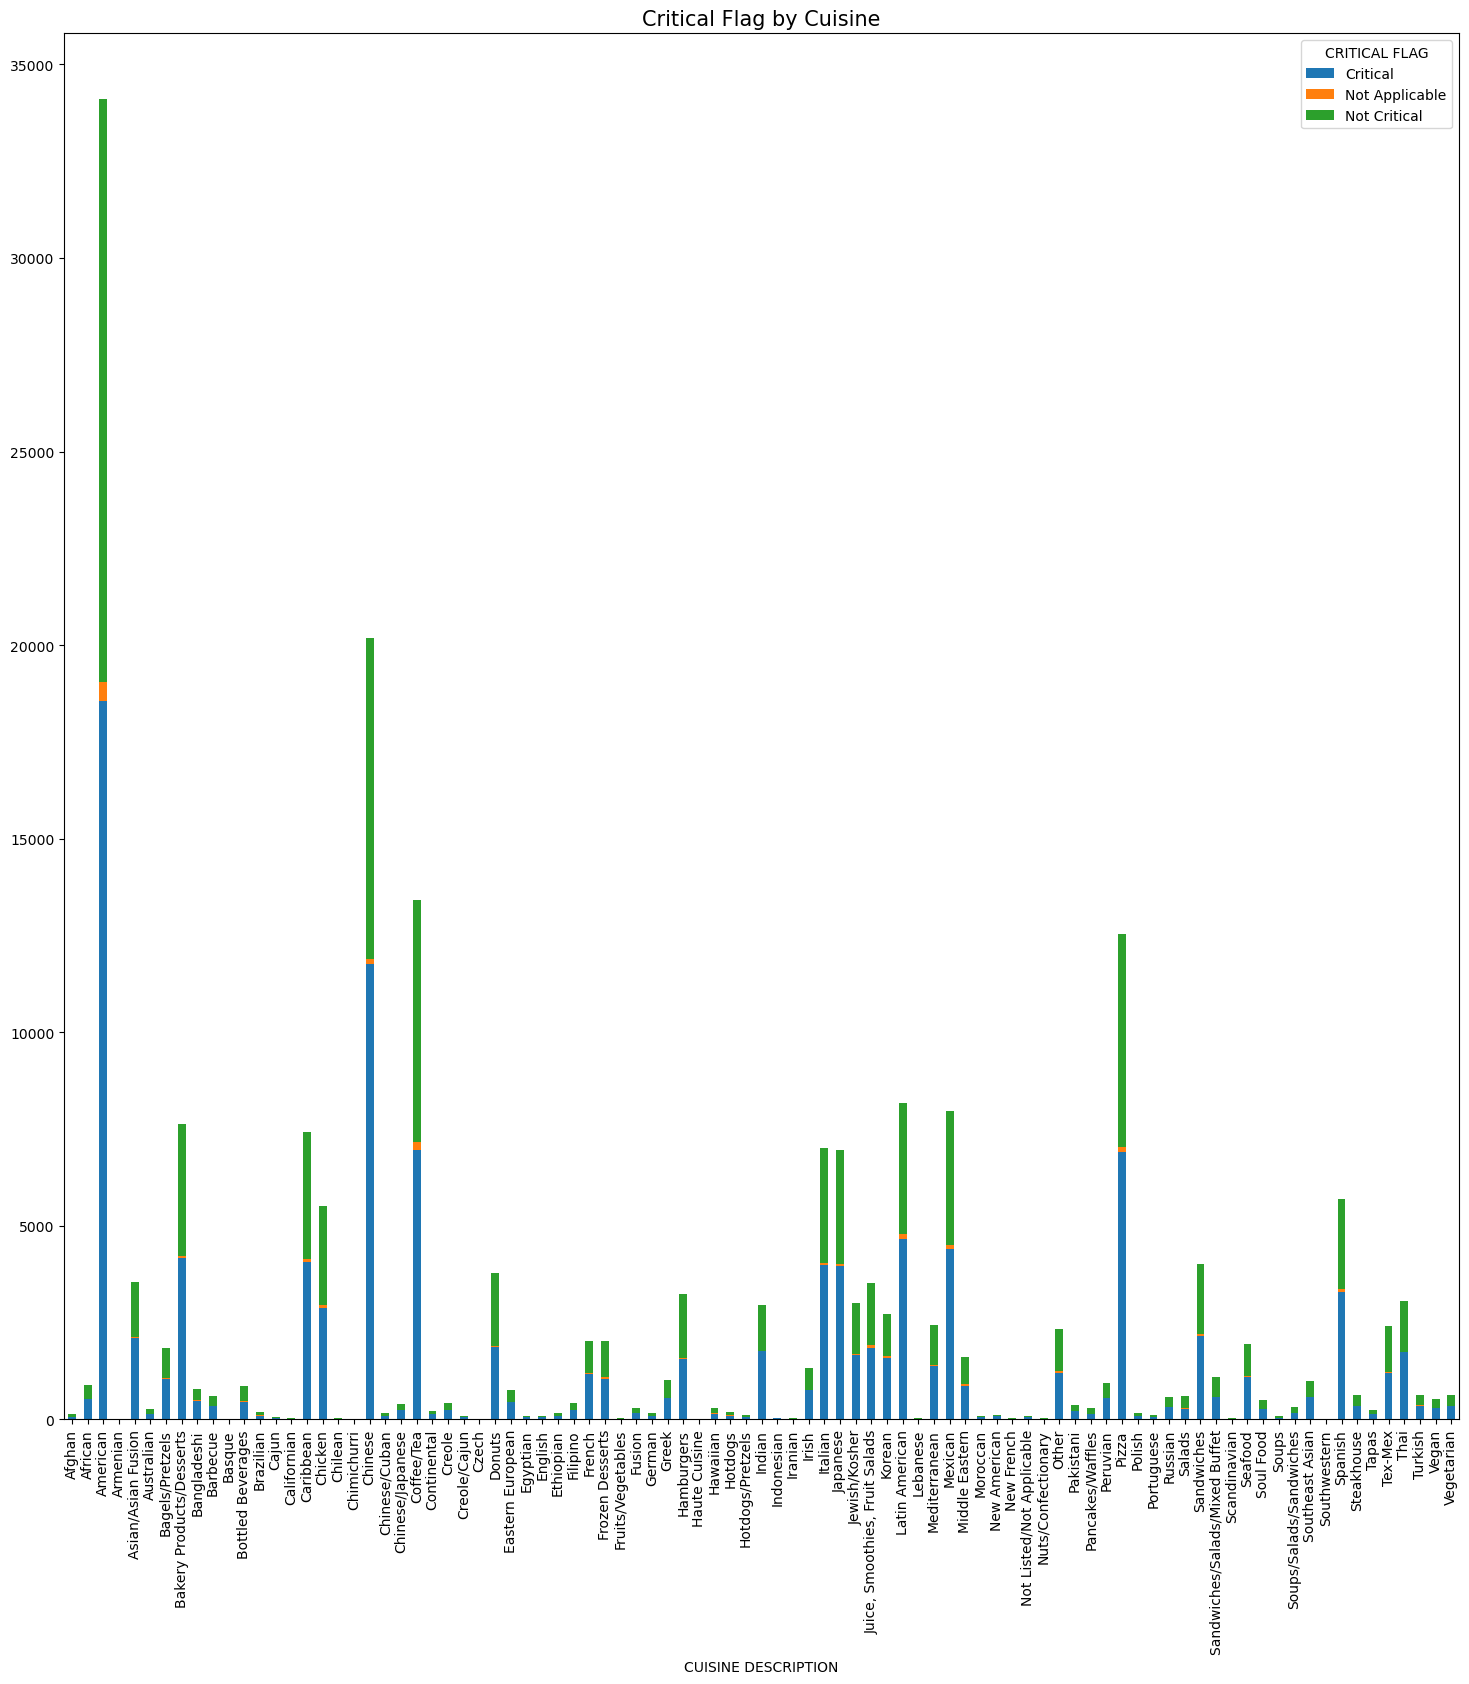

In [31]:
# Critical Flag by Cuisine
pd.crosstab(rdf['CUISINE DESCRIPTION'], rdf['CRITICAL FLAG']).plot(kind="bar", figsize=(18,18), stacked=True)
plt.title('Critical Flag by Cuisine', fontsize = 15)

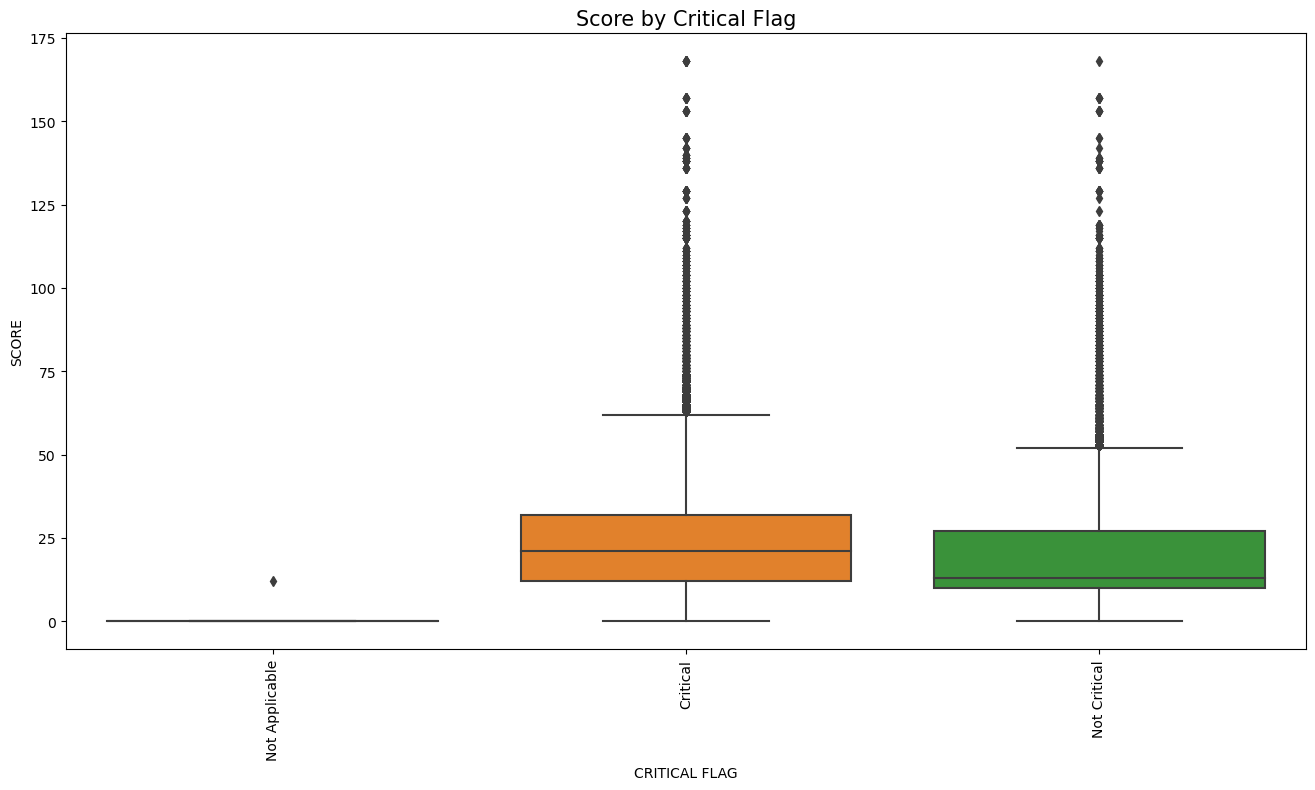

In [32]:
# Let us look at the scores by critical flag
score_flag = pd.concat([rdf['CRITICAL FLAG'], rdf['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CRITICAL FLAG', y="SCORE", data = score_flag)
plt.title('Score by Critical Flag', fontsize = 15)
plt.xticks(rotation=90);

# **Text Visual**

In [33]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    temp = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()

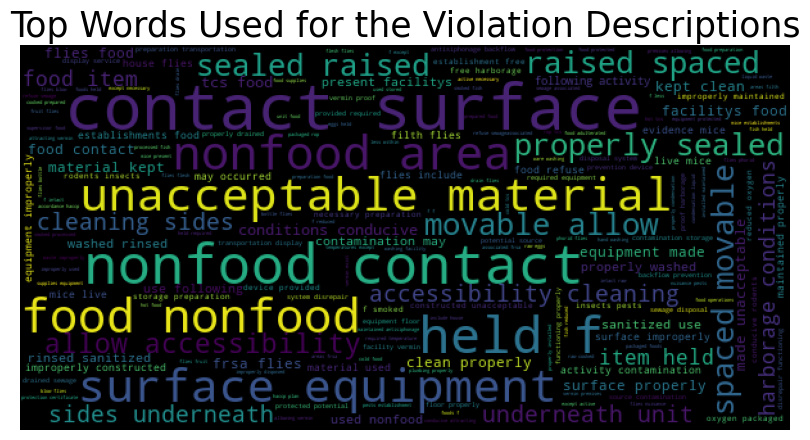

In [34]:
# Let us create a word cloud for the violation description
temp_data = rdf.dropna(subset=['VIOLATION DESCRIPTION'])
# converting into lowercase
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].map(text_prepare)
# Wordcloud visual for most used words for Violation Desriptions
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['VIOLATION DESCRIPTION'].values))
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.title("Top Words Used for the Violation Descriptions", fontsize=25)
plt.axis("off")
plt.show() 